In [12]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from detection_lib import *
%matplotlib inline

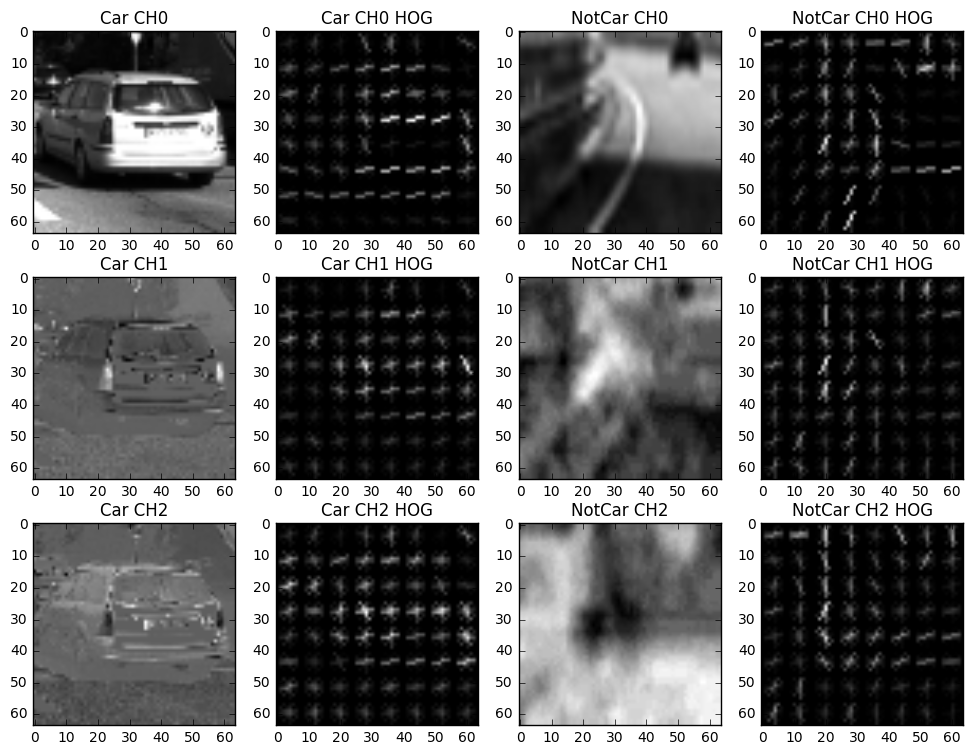

In [37]:
### Extract HOG feature from Random image
car_name = './data/vehicles/KITTI_extracted/54.png'
notcar_name = './data/non-vehicles/GTI/image54.png'

orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 1 # Can be 0, 1, 2, or "ALL"

#RGB image
car_image = mpimg.imread(car_name)
notcar_image = mpimg.imread(notcar_name)
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

#Car
features, car_hog_image0 = get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, car_hog_image1 = get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, car_hog_image2 = get_hog_features(car_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
# not car
features, notcar_hog_image0 = get_hog_features(notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, notcar_hog_image1 = get_hog_features(notcar_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, notcar_hog_image2 = get_hog_features(notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(12,9))
plt.subplot(341)
plt.imshow(car_image[:,:,0], cmap='gray')
plt.title('Car CH0')
plt.subplot(342)
plt.imshow(car_hog_image0, cmap='gray')
plt.title('Car CH0 HOG')
plt.subplot(343)
plt.imshow(notcar_image[:,:,0], cmap='gray')
plt.title('NotCar CH0')
plt.subplot(344)
plt.imshow(notcar_hog_image0, cmap='gray')
plt.title('NotCar CH0 HOG')

plt.subplot(345)
plt.imshow(car_image[:,:,1], cmap='gray')
plt.title('Car CH1')
plt.subplot(346)
plt.imshow(car_hog_image1, cmap='gray')
plt.title('Car CH1 HOG')
plt.subplot(347)
plt.imshow(notcar_image[:,:,1], cmap='gray')
plt.title('NotCar CH1')
plt.subplot(348)
plt.imshow(notcar_hog_image1, cmap='gray')
plt.title('NotCar CH1 HOG')

plt.subplot(349)
plt.imshow(car_image[:,:,2], cmap='gray')
plt.title('Car CH2')
plt.subplot(3,4,10)
plt.imshow(car_hog_image2, cmap='gray')
plt.title('Car CH2 HOG')
plt.subplot(3,4,11)
plt.imshow(notcar_image[:,:,2], cmap='gray')
plt.title('NotCar CH2')
plt.subplot(3,4,12)
plt.imshow(notcar_hog_image2, cmap='gray')
plt.title('NotCar CH2 HOG')

In [49]:
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')
print(len(cars))
print(len(notcars))

8792
8968


In [50]:
# train a linear SVM
# Read in cars and notcars
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.995


FileNotFoundError: [Errno 2] No such file or directory: 'bbox-example-image.jpg'